# Generate caravan Map
In this notebook you will retrieve the geospatial data for the Cravan dataset.The caravan dataset is a collection of streamflow and forcing data. <br>
Caravan was prepared by [Frederik Kratzert](https://doi.org/10.1038/s41597-023-01975-w), the forcing is based on the ERA5-Land model. The streamflow is from the USGS. <br>
To access it easily, it was stored [here](https://doi.org/10.4121/bf0eaf7c-f2fa-46f6-b8cd-77ad939dd350.v4) on the [OPenDAP](https://data.4tu.nl/info/about-your-data/netcdf-and-opendap) server from data.4TU.nl .<br>
This saves you from downloading and reading the whole dataset hosted on [zenodo](https://zenodo.org/records/6578598), instead only the necesarry data is downloaded. 

This notebook will show case how to turn this into an easily accessible map.  

This supplies you with the basin_id.
The shapefiles will be downloaded automatically and the catchment information downloaded from the server


In [1]:
import wget
from zipp import zipfile
from pathlib import Path
import geopandas as gpd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import pandas as pd

import requests
from bs4 import BeautifulSoup
import numpy as np

import folium

Specify url

In [2]:
COMMON_URL = "ca13056c-c347-4a27-b320-930c2a4dd207"
OPENDAP_URL = f"https://opendap.4tu.nl/thredds/dodsC/data2/djht/{COMMON_URL}/1/"
SHAPEFILE_URL = (
    f"https://data.4tu.nl/file/{COMMON_URL}/bbe94526-cf1a-4b96-8155-244f20094719"
)

Download the required shapefiles from [data.4TU.nl](https://doi.org/10.4121/bf0eaf7c-f2fa-46f6-b8cd-77ad939dd350.v4)

In [3]:
out_path = Path('shapefiles')
if not out_path.exists():
    out_path.mkdir()
zip_path = out_path / 'shapefiles.zip'
if not zip_path.is_file():
    wget.download(SHAPEFILE_URL, out=str(out_path))

In [4]:
combined_shapefile_path = out_path / "combined.shp"
if not combined_shapefile_path.is_file():
    with zipfile.ZipFile(zip_path) as myzip:
        myzip.extractall()

Load in the dataset

In [5]:
gdf = gpd.read_file(combined_shapefile_path)

In [6]:
dataset_names = list(set(gdf['gauge_id'].apply(lambda x: x.split('_')[0]).values))
dataset_names

['camelsbr', 'camelsgb', 'camelscl', 'camels', 'hysets', 'camelsaus', 'lamah']

In [7]:
map_path = Path('docs')
if not out_path.exists():
    out_path.mkdir()

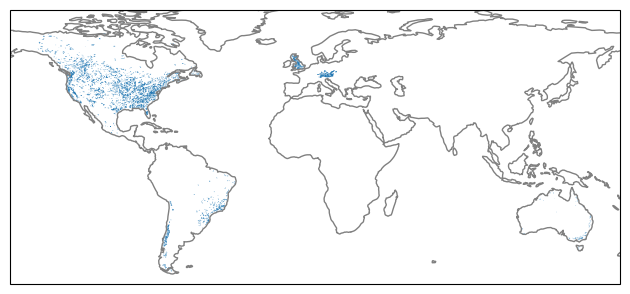

In [9]:
ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE, edgecolor='gray')
gdf.plot(ax=ax,zorder=1,color="C0")
plt.tight_layout()
plt.savefig(map_path / 'overview_image.png',bbox_inches='tight',dpi=400)

# Load data

In [14]:
import xarray as xr

In [15]:
 def get_camels_ids(dataset: str):
    ds = xr.open_dataset(f"{OPENDAP_URL}{dataset}.nc")
    return np.array([basin.decode() for basin in ds['basin_id'].values])

In [16]:
 def get_caravan(dataset: str, basin_id: str):
    ds = xr.open_dataset(f"{OPENDAP_URL}{dataset}.nc")
    return ds.sel(basin_id=basin_id.encode())

In [17]:
def get_dataset(dataset) -> xr.Dataset:
    """Opens specified dataset from data.4tu.nl OPeNDAP server.
    Args:
        dataset (str): name of dataset, choose from:
            'camels',
            'camelsaus',
            'camelsbr',
            'camelscl',
            'camelsgb',
            'hysets',
            'lamah'
    """
    return xr.open_dataset(f"{OPENDAP_URL}{dataset}.nc")


In [18]:
get_camels_ids(dataset_names[-1])[0]

'lamah_105'

In [21]:
basin_id= "camels_01022500"
ds = get_caravan("camels", basin_id)

In [22]:
PROPERTY_VARS = [
    "timezone",
    "name",
    "country",
    "lat",
    "lon",
    "area",
    "p_mean",
    "pet_mean",
    "aridity",
    "frac_snow",
    "moisture_index",
    "seasonality",
    "high_prec_freq",
    "high_prec_dur",
    "low_prec_freq",
    "low_prec_dur",
]
RENAME_ERA5 = {
    "total_precipitation_sum": "pr",
    "potential_evaporation_sum": "evspsblpot",
    "temperature_2m_mean": "tas",
    "temperature_2m_min": "tasmin",
    "temperature_2m_max": "tasmax",
    "streamflow": "Q",
}

In [23]:
ds

<xarray.Dataset>
Dimensions:                             (time: 14609)
Coordinates:
  * time                                (time) datetime64[ns] 1981-01-01 ... ...
    basin_id                            |S64 b'camels_01022500'
Data variables: (12/55)
    timezone                            |S64 ...
    name                                |S64 ...
    country                             |S64 ...
    lat                                 float64 ...
    lon                                 float64 ...
    area                                float64 ...
    ...                                  ...
    volumetric_soil_water_layer_2_max   (time) float32 ...
    volumetric_soil_water_layer_3_max   (time) float32 ...
    volumetric_soil_water_layer_4_max   (time) float32 ...
    total_precipitation_sum             (time) float32 ...
    potential_evaporation_sum           (time) float32 ...
    streamflow                          (time) float32 ...
Attributes:
    history:  Wed Mar 27 16:11:00 2024: /usr/bin/ncap2 -s time=double(time) -...
    NCO:      netCDF Operators version 5.0.6 (Homepage = http://nco.sf.net, C...

In [24]:
lst_df_info = []
for dataset_name in dataset_names:
    ds = get_dataset(dataset_name)
    variables = ds.data_vars.keys()
    properties = set(variables).intersection(PROPERTY_VARS)
    non_property_vars = set(variables) - properties
    variable_names = non_property_vars.intersection(
        RENAME_ERA5.keys()
    )  # only take the vars also in Rename dict
    ds = ds.drop_vars(non_property_vars)
    ds = ds.drop_indexes("time")
    ds = ds.drop_vars("time")
    ds['basin_id'] = [val.decode() for val in ds['basin_id'].values]
    
    df_info = ds.to_dataframe()
    for val in ['timezone','name', 'country']:
        df_info[val] = df_info[val].apply(lambda x: x.decode('ISO-8859–1'))
    
    lst_df_info.append(df_info)

In [25]:
df_combined_info = pd.concat(lst_df_info).sort_index()

In [26]:
df_combined_info['basin_id'] = df_combined_info.index

In [27]:
if 'gauge_id' in gdf.columns:
    gdf = gdf.set_index('gauge_id')

In [28]:
for val in df_combined_info.keys():
    gdf[val] = df_combined_info[val]

In [29]:
# add to gdf

In [30]:
gdf[['timezone','name','country']]

timezone  \
gauge_id                            
camels_01022500  America/New_York   
camels_01031500  America/New_York   
camels_01047000  America/New_York   
camels_01052500  America/New_York   
camels_01054200  America/New_York   
...                           ...   
lamah_47840         Europe/Berlin   
lamah_76175         Europe/Berlin   
lamah_76176         Europe/Berlin   
lamah_76184         Europe/Berlin   
lamah_76276         Europe/Berlin   

                                                         name  \
gauge_id                                                        
camels_01022500       Narraguagus River at Cherryfield, Maine   
camels_01031500  Piscataquis River near Dover-Foxcroft, Maine   
camels_01047000    Carrabassett River near North Anson, Maine   
camels_01052500     Diamond River near Wentworth Location, NH   
camels_01054200                   Wild River at Gilead, Maine   
...                                                       ...   
lamah_47840                               Kanzach at Unlingen   
lamah_76175                                       Blau at Ulm   
lamah_76176                                 Eger at Bopfingen   
lamah_76184                       Schmiech at Ehingen-Berkach   
lamah_76276                                  Brenz at Bolheim   

                                  country  
gauge_id                                   
camels_01022500  United States of America  
camels_01031500  United States of America  
camels_01047000  United States of America  
camels_01052500  United States of America  
camels_01054200  United States of America  
...                                   ...  
lamah_47840                       Germany  
lamah_76175                       Germany  
lamah_76176                       Germany  
lamah_76184                       Germany  
lamah_76276                       Germany  

[6830 rows x 3 columns]

Turn it into a Map using folium

In [31]:
# control_bool = True
# caravan_map = folium.Map(
#                     # location        = [NL_outline.iloc[0].geometry.centroid.y, NL_outline.iloc[0].geometry.centroid.x],
#                     # zoom_start      = 8,
#                     # zoom_control    = control_bool,
#                     # scrollWheelZoom = control_bool,
#                     # dragging        = control_bool
#                     )

# catchments = gdf.to_crs(epsg=4326)

# folium.features.GeoJson(catchments,).add_to(caravan_map)

In [32]:
# # icon = folium.features.Icon(color="blue",icon="none")

# gjson = folium.features.GeoJson(
#                                 gdf,
#                                 # marker = folium.features.Marker(icon=icon)
#                                 ).add_to(caravan_map)

# # create
# popup = folium.features.GeoJsonPopup(
#     fields=['name','country','basin_id'],

# ).add_to(gjson)

In [33]:
# caravan_map.save(f"caravan_catchments_map.html")

### Too big, split per contry: 

In [34]:
countries = gdf['country'].unique()

In [35]:
import warnings
warnings.simplefilter("ignore") # centroid gives : UserWarning: Geometry is in a geographic CRS

In [44]:
countries

array(['United States of America', 'Australia', 'Brazil', 'Chile',
       'Scotland', 'England', 'Wales', 'Canada', 'Mexico', 'Germany',
       'Switzerland', 'Austria', 'Lichtenstein', 'Czech Republic'],
      dtype=object)

In [40]:
# fix issue of overlapping polygons
gdf = gdf.sort_values("area",ascending=False)

In [41]:
for country in countries:
    gdf_country = gdf[gdf['country'] == country]
    country_map = folium.Map(
                        location        = [np.mean(gdf_country.geometry.centroid.y), np.mean(gdf_country.geometry.centroid.x)],
                        zoom_start      = 6,
                        )

    catchments_country = gdf_country.to_crs(epsg=4326)
    
    folium.features.GeoJson(catchments_country,).add_to(country_map)
    gjson = folium.features.GeoJson(
                                gdf_country,
                                # marker = folium.features.Marker(icon=icon)
                                ).add_to(country_map)

    # create
    popup = folium.features.GeoJsonPopup(
        fields=['basin_id','name','country','area',
       'p_mean', 'pet_mean', 'aridity', 'frac_snow', 'moisture_index',
       'seasonality', 'high_prec_freq', 'high_prec_dur', 'low_prec_freq',
       'low_prec_dur'],
    
    ).add_to(gjson)

    country_map.save(map_path / f"caravan_catchments_map_{country.replace(' ','_')}.html")   